### Reading the csv data files and creating two data-frames called train and test

In [1]:
pip install imblearn

     |████████████████████████████████| 199 kB 33.0 MB/s            
     |████████████████████████████████| 189 kB 83.7 MB/s            
Note: you may need to restart the kernel to use updated packages.


In [2]:
import boto3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, classification_report, precision_recall_curve, f1_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import Lasso, LassoCV, LinearRegression, Ridge, RidgeCV
from imblearn.over_sampling import SMOTE


# Defining the s3 bucket
s3 = boto3.resource('s3')
bucket_name = 'gabriel-predictive-analytics'
bucket = s3.Bucket(bucket_name)

# Defining the file to be read from s3 bucket
file_key_train = "train.csv"
bucket_object = bucket.Object(file_key_train)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

# Reading the csv file
train = pd.read_csv(file_content_stream, sep="|")

# Defining the file to be read from s3 bucket
file_key_test = "test.csv"
bucket_object_test = bucket.Object(file_key_test)
file_object_test = bucket_object_test.get()
file_content_stream_test = file_object_test.get('Body')

# Reading the csv file
test = pd.read_csv(file_content_stream_test, sep='|')

### Checking train dataset

In [3]:
train.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
0,5,1054,54.70,7,0,3,0.027514,0.051898,0.241379,0
1,3,108,27.36,5,2,4,0.129630,0.253333,0.357143,0
2,3,1516,62.16,3,10,5,0.008575,0.041003,0.230769,0
3,6,1791,92.31,8,4,4,0.016192,0.051541,0.275862,0
4,5,430,81.53,3,7,2,0.062791,0.189605,0.111111,0


### Building Models

In [4]:
## Selecting input and target variables
X = train[["trustLevel", "totalScanTimeInSeconds", "grandTotal", "lineItemVoids",  "scannedLineItemsPerSecond", 'valuePerSecond', "lineItemVoidsPerPosition"]]
Y = train['fraud']

# Spliting the train dataset into train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)

### Applying the SMOTE technique on the subset data

In [5]:
# Running SMOTE
X_SMOTE, Y_SMOTE = SMOTE().fit_resample(X_train, Y_train)

### Random Forest model

In [6]:
### Random Forest Classifier model with max_depth = 3
rf_md = RandomForestClassifier(n_estimators = 500, max_depth = 3).fit(X_SMOTE, Y_SMOTE)
    
# Predicting on test dataset
rf_pred = rf_md.predict_proba(X_test)[:, 1]

# Computing precision_recall_curve
precision, recall, threshold = precision_recall_curve(Y_test, rf_pred)

# Creating a data-frame
cutoffs = pd.DataFrame({'Precision': precision, 'Recall': recall})
cutoffs = cutoffs.tail(cutoffs.shape[0] -1)
cutoffs['Cutoff'] = threshold

# Finding the optimal cut-off
cutoffs['Euclidean_dist'] = np.sqrt((1 - cutoffs['Precision'])**2 + (1 - cutoffs['Recall'])**2)

## Sorting based on the Euclidean distance
cutoffs = cutoffs.sort_values(by = 'Euclidean_dist').reset_index(drop = True).head(3)

## Changing likelihoods to labels
rf_pred = np.where(rf_pred < cutoffs['Cutoff'][0], 0, 1)

# Printing classification report
round(f1_score(Y_test, rf_pred),2)

0.72

### AdaBoost model

In [7]:
#### AdaBoost Classifier
Ada_md = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 3), n_estimators = 500, learning_rate = 0.01).fit(X_SMOTE, Y_SMOTE)
    
# Predicting on test
ADA_pred = Ada_md.predict_proba(X_test)[:,1]

# Computing precision_recall_curve
precision, recall, threshold = precision_recall_curve(Y_test, ADA_pred)

# Creating a data-frame
cutoffs_ADA = pd.DataFrame({'Precision': precision, 'Recall': recall})
cutoffs_ADA = cutoffs_ADA.tail(cutoffs_ADA.shape[0] -1)
cutoffs_ADA['Cutoff'] = threshold

# Finding the optimal cut-off
cutoffs_ADA['Euclidean_dist'] = np.sqrt(((1 - cutoffs['Precision'])**2) + ((1 - cutoffs['Recall'])**2))

## Sorting based on the Euclidean distance
cutoffs_ADA = cutoffs_ADA.sort_values(by = 'Euclidean_dist').reset_index(drop = True)

## Changing likelihoods to labels
ADA_pred = np.where(ADA_pred < cutoffs_ADA['Cutoff'][0], 0, 1)

# Printing classification report
round(f1_score(Y_test, ADA_pred), 2)

0.75

### Repeating these process 100 times to get a solid result

In [8]:
RF_f1_scores = list()
ADA_f1_scores = list()

for i in range(0, 100):
    
    ## Selecting input and target variables
    X = train[["trustLevel", "totalScanTimeInSeconds", "grandTotal", "lineItemVoids",  "scannedLineItemsPerSecond", 'valuePerSecond', "lineItemVoidsPerPosition"]]
    Y = train['fraud']

    # Spliting the train dataset into train and test
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)
    
    # Running SMOTE
    X_SMOTE, Y_SMOTE = SMOTE().fit_resample(X_train, Y_train)

    ### Random Forest Classifier model with max_depth = 3
    rf_md = RandomForestClassifier(n_estimators = 500, max_depth = 3).fit(X_SMOTE, Y_SMOTE)

    # Predicting on test dataset
    rf_pred = rf_md.predict_proba(X_test)[:, 1]

    # Computing precision_recall_curve
    precision, recall, threshold = precision_recall_curve(Y_test, rf_pred)

    # Creating a data-frame
    cutoffs = pd.DataFrame({'Precision': precision, 'Recall': recall})
    cutoffs = cutoffs.tail(cutoffs.shape[0] -1)
    cutoffs['Cutoff'] = threshold

    # Finding the optimal cut-off
    cutoffs['Euclidean_dist'] = np.sqrt((1 - cutoffs['Precision'])**2 + (1 - cutoffs['Recall'])**2)

    ## Sorting based on the Euclidean distance
    cutoffs = cutoffs.sort_values(by = 'Euclidean_dist').reset_index(drop = True).head(3)

    ## Changing likelihoods to labels
    rf_pred = np.where(rf_pred < cutoffs['Cutoff'][0], 0, 1)

    # Printing classification report
    RF_f1_scores.append(round(f1_score(Y_test, rf_pred),2))

    #### AdaBoost Classifier
    Ada_md = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 3), n_estimators = 500, learning_rate = 0.01).fit(X_SMOTE, Y_SMOTE)

    # Predicting on test
    ADA_pred = Ada_md.predict_proba(X_test)[:,1]

    # Computing precision_recall_curve
    precision, recall, threshold = precision_recall_curve(Y_test, ADA_pred)

    # Creating a data-frame
    cutoffs_ADA = pd.DataFrame({'Precision': precision, 'Recall': recall})
    cutoffs_ADA = cutoffs_ADA.tail(cutoffs_ADA.shape[0] -1)
    cutoffs_ADA['Cutoff'] = threshold

    # Finding the optimal cut-off
    cutoffs_ADA['Euclidean_dist'] = np.sqrt(((1 - cutoffs['Precision'])**2) + ((1 - cutoffs['Recall'])**2))

    ## Sorting based on the Euclidean distance
    cutoffs_ADA = cutoffs_ADA.sort_values(by = 'Euclidean_dist').reset_index(drop = True)

    ## Changing likelihoods to labels
    ADA_pred = np.where(ADA_pred < cutoffs_ADA['Cutoff'][0], 0, 1)

    # Printing classification report
    ADA_f1_scores.append(round(f1_score(Y_test, ADA_pred), 2))
    
    if (i==0):
        print("Iteration:", i, end=' ')
    else:    
        print(i, end=" ")

Iteration: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

### Average of f1-score provided by the Random Forest Classifier Model

In [9]:
print("The average of f1-score provided by the Random Forest Classifier model is: ", round(np.mean(RF_f1_scores),2))

The average of f1-score provided by the Random Forest Classifier model is:  0.65


### Average of f1-score provided by the AdaBoost Classifier Model

In [10]:
print("The average of f1-score provided by the AdaBoost Classifier model using Decision tree is: ", round(np.mean(ADA_f1_scores),2))

The average of f1-score provided by the AdaBoost Classifier model using Decision tree is:  0.45


### Visualizing individuals f1-scores provided by both models

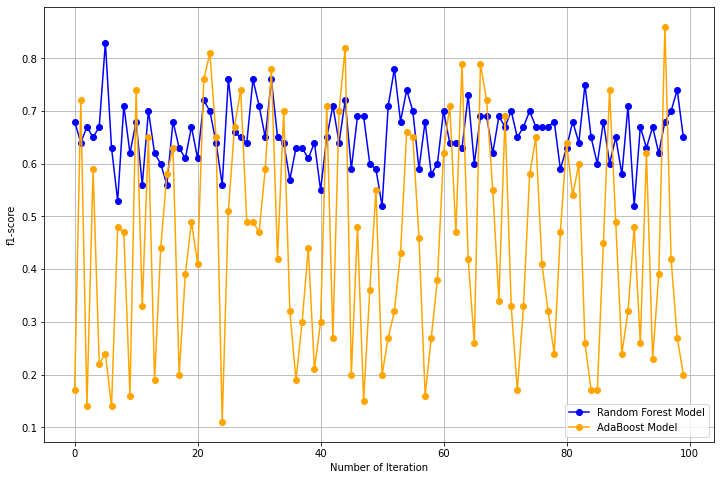

In [11]:
f1_scores = pd.DataFrame({'RF_f1_score': RF_f1_scores, 'ADA_f1_score': ADA_f1_scores})

# Visualizing f1-score of the Random Forest model

## Plotting iteration results
fig = plt.figure(figsize = (12, 8))

iterations = range(0, 100)

plt.plot(iterations, RF_f1_scores, marker = 'o', color = 'blue',
         label = 'Random Forest Model')
plt.plot(iterations, ADA_f1_scores, marker = 'o', color = 'orange',
        label = 'AdaBoost Model')
plt.xlabel('Number of Iteration')
plt.ylabel('f1-score')
plt.legend()
plt.grid()
plt.show()

### Based on the results of the above models, I would use Random Forest Model to predict customer fraud because it had, on average, better and more consistent f1-scores.